## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


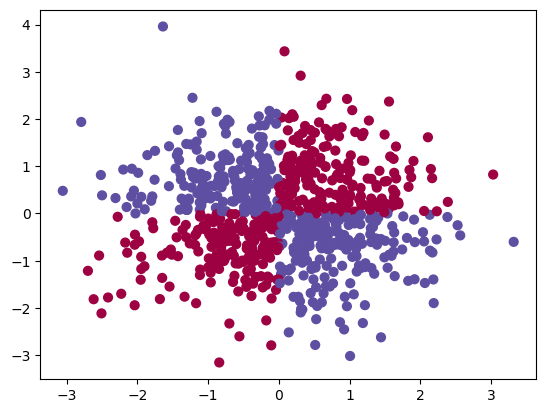

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [44]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x): 
    return np.maximum(x, 0)

def relu_derivative(x):
    return np.where(x > 0, 1, 0) 

def cross_entropy(y_pred, y_target):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.mean(y_target * np.log(y_pred) + (1 - y_target) * np.log(y_pred))

def cross_validate(X, y, kfold = 10):
    fold_metrics = [] 
    m = X.shape[0]
    fold_size = m // kfold 
    indices = np.arange(m) 
    shuffled_indices = np.random.permutation(indices) 
    
    for i in range(0, m, fold_size):
        test_idx = range(i, (min(i + fold_size, m)))
        X_train = np.delete(X, test_idx, axis=0)
        y_train = np.delete(y, test_idx, axis=0)
        
        X_test = X[test_idx]
        y_test = y[test_idx] 
        
        W1, b1, W2, b2 = SGD(X_train, y_train, X_test, y_test) 
        _, _, _, y_test_pred = forward_prop(X_test, W1, b1, W2, b2) 
        
        y_test_pred = (y_test_pred > 0.5).astype(int) 
        metrics = classification_report(y_test, y_test_pred, output_dict=True)
        fold_metrics.append(metrics["accuracy"])
    print(f"\nMean CV accuracy is {np.mean(fold_metrics):.4f}")   
    return fold_metrics

def initialize_param():
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01 
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01 
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

def forward_prop(X, W1, b1, W2, b2):
    A1 = np.dot(X, W1) + b1 
    Z1 = relu(A1) 
    A2 = np.dot(Z1, W2) + b2 
    Z2 = sigmoid(A2) 
    return A1, Z1, A2, Z2

def backward_prop(X, y, A1, Z1, A2, W2): 

    Z2 = sigmoid(A2)
    dZ2 = Z2 - y.reshape(-1, 1)  # Error at output layer
    dW2 = np.dot(Z1.T, dZ2) / X.shape[0]  # Gradient w.r.t. W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X.shape[0]  # Gradient w.r.t. b2  
    dA1 = np.dot(dZ2, W2.T)  # Propagate error to hidden layer
    dZ1 = dA1 * relu_derivative(A1)  # Apply ReLU derivative
    dW1 = np.dot(X.T, dZ1) / X.shape[0]  # Gradient w.r.t. W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X.shape[0]  # Gradient w.r.t. b1
    return dW1, db1, dW2, db2
    
def SGD(X_train, y_train, X_test, y_test): 
    W1, b1, W2, b2 = initialize_param() 
    m = X_train.shape[0]
    for epoch in range(epochs): 
        perm = np.random.permutation(m) 
        X_train_shuffled = X_train[perm] 
        y_train_shuffled = y_train[perm] 
        
        for i in range(0, m, batch_size): 
            X_batch = X_train_shuffled[i:i+batch_size] 
            y_batch = y_train_shuffled[i:i+batch_size] 
            
            A1, Z1, A2, Z2 = forward_prop(X_batch, W1, b1, W2, b2) 
            loss_entropy = cross_entropy(Z2, y_batch) 
            
            dW1, db1, dW2, db2 = backward_prop(X_batch, y_batch, A1, Z1, A2, W2) 
            
            # Update weights and biases
            W1 -= alpha * dW1
            b1 -= alpha * db1
            W2 -= alpha * dW2
            b2 -= alpha * db2
            
            # Print loss every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss_entropy:.4f}")
                
    return W1, b1, W2, b2
    
    
# Hyperparameters: 
epochs = 1000
batch_size = 32
alpha = 0.01 
input_dim = 2 # There are 2 features in the data set 
hidden_dim = 11  #Hyperparameter, subject to tuning (CV)
output_dim = 1  # 1 neuron output for binary classification 

m = X_train.shape[0]


In [46]:
# Perform CV to estimate perfomrance on test set 
train_out = cross_validate(X_train, y_train, 10)

Epoch 0/1000, Loss: 0.6932
Epoch 0/1000, Loss: 0.6929
Epoch 0/1000, Loss: 0.6921
Epoch 0/1000, Loss: 0.6919
Epoch 0/1000, Loss: 0.6918
Epoch 0/1000, Loss: 0.6918
Epoch 0/1000, Loss: 0.6921
Epoch 0/1000, Loss: 0.6933
Epoch 0/1000, Loss: 0.6926
Epoch 0/1000, Loss: 0.6929
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6929
Epoch 0/1000, Loss: 0.6929
Epoch 0/1000, Loss: 0.6930
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6920
Epoch 0/1000, Loss: 0.6921
Epoch 0/1000, Loss: 0.6916
Epoch 0/1000, Loss: 0.6919
Epoch 0/1000, Loss: 0.6918
Epoch 0/1000, Loss: 0.6924
Epoch 0/1000, Loss: 0.6917
Epoch 0/1000, Loss: 0.6916
Epoch 100/1000, Loss: 0.6659
Epoch 100/1000, Loss: 0.6658
Epoch 100/1000, Loss: 0.6653
Epoch 100/1000, Loss: 0.6656
Epoch 100/1000, Loss: 0.6649
Epoch 100/1000, Loss: 0.6658
Epoch 100/1000, Loss: 0.6658
Epoch 100/1000, Loss: 0.6654
Epoch 100/1000, Loss: 0.6653
Epoch 100/1000, Loss: 0.6654
Epoch 100/1000, Loss: 0.6665
Epoch 100/1000, Loss: 0.6664
Epoch 100/1000, Loss: 0.6657
Ep

In [45]:
# Perform on the test set 
W1, b1, W2, b2 = SGD(X_train, y_train, X_test, y_test)
_, _, _, y_test_pred = forward_prop(X_test, W1, b1, W2, b2) 
y_test_pred = (y_test_pred > 0.5).astype(int) 
print("Classfication Report on the Test Set: \n")
print(classification_report(y_test, y_test_pred))

Epoch 0/1000, Loss: 0.6932
Epoch 0/1000, Loss: 0.6927
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6930
Epoch 0/1000, Loss: 0.6936
Epoch 0/1000, Loss: 0.6930
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6929
Epoch 0/1000, Loss: 0.6930
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6925
Epoch 0/1000, Loss: 0.6921
Epoch 0/1000, Loss: 0.6916
Epoch 0/1000, Loss: 0.6919
Epoch 0/1000, Loss: 0.6912
Epoch 0/1000, Loss: 0.6910
Epoch 0/1000, Loss: 0.6911
Epoch 0/1000, Loss: 0.6912
Epoch 0/1000, Loss: 0.6912
Epoch 0/1000, Loss: 0.6907
Epoch 0/1000, Loss: 0.6907
Epoch 0/1000, Loss: 0.6912
Epoch 0/1000, Loss: 0.6915
Epoch 0/1000, Loss: 0.6914
Epoch 0/1000, Loss: 0.6907
Epoch 100/1000, Loss: 0.6613
Epoch 100/1000, Loss: 0.6619
Epoch 100/1000, Loss: 0.6621
Epoch 100/1000, Loss: 0.6618
Epoch 100/1000, Loss: 0.6617
Epoch 100/1000, Loss: 0.6615
Epoch 100/1000, Loss: 0.6606
Epoch 100/1000, Loss: 0.6600
Epoch 100/1000, Loss: 0.6603
Epoch 100/1000, Loss: 0.6602
Epoch 100/1000, Loss: 0.6595
Epoch 

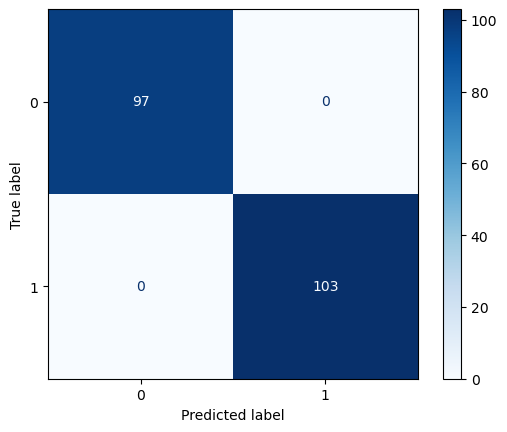

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
matrix = confusion_matrix(y_test_pred, y_test) 

# Display the confusion matrix 
ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap = "Blues")


Summary 

In this 2-layer neural network model, I set the input layer dimension to be 2 to match the number of features of the data set and 1 dimension in the output layer since this is a binary classification. The dimensions of the hidden layer, along with batch size, learning rate, and epochs are all hyperparameters that are subject to tuning. I eventually settled at having 11 dimensions in the hidden layer and that is able to achieve a 98.75% accuracy on the training set and 100% accuracy on the testing set. 